In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

from numpy.polynomial.hermite import hermgauss
import scipy as osp

from vb_lib import structure_model_lib, data_utils, cavi_lib, structure_optimization_lib
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul

import paragami
import vittles

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib
from bnpmodeling_runjingdev.sensitivity_lib import get_jac_hvp_fun

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
onp.random.seed(53453)

# Draw data

In [3]:
n_obs = 200
n_loci = 500
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

Generating datapoints  0  to  200


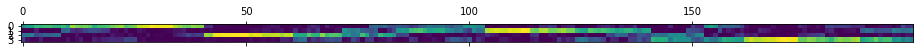

In [5]:
plt.matshow(true_ind_admix_propn.T)

In [6]:
g_obs = np.array(g_obs)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'dp_prior_alpha': DeviceArray([3.], dtype=float64), 'allele_prior_alpha': DeviceArray([1.], dtype=float64), 'allele_prior_beta': DeviceArray([1.], dtype=float64)}


# Get VB params 

In [8]:
k_approx = 15

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (500, 15, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (200, 14, 2) (lb=0.0, ub=inf)


## Initialize 

In [11]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                seed = 143241)

In [12]:
structure_model_lib.get_kl(g_obs, vb_params_dict, prior_params_dict,
                            gh_loc, gh_weights)

DeviceArray(482925.84029194, dtype=float64)

In [13]:
vb_params_free = vb_params_paragami.flatten(vb_params_dict, free = True)

In [14]:
import inspect
lines = inspect.getsource(structure_model_lib.get_e_loglik)
print(lines)


def get_e_loglik(g_obs,
                    e_log_pop_freq, e_log_1m_pop_freq, \
                    e_log_sticks, e_log_1m_sticks,
                    detach_ez):

    # outer loop through n

    e_log_cluster_probs = \
        modeling_lib.get_e_log_cluster_probabilities_from_e_log_stick(
                            e_log_sticks, e_log_1m_sticks)

    with loops.Scope() as s:
        s.e_loglik = 0.
        s.z_entropy = 0.
        for n in s.range(g_obs.shape[0]):
            for l in s.range(g_obs.shape[1]):
                e_loglik_ln, z_entropy_ln = get_e_loglik_nl(g_obs[n, l],
                                        e_log_pop_freq[l], e_log_1m_pop_freq[l],
                                        e_log_cluster_probs[n], detach_ez)

                s.e_loglik += e_loglik_ln
                s.z_entropy += z_entropy_ln

    return s.e_loglik, s.z_entropy



# Define objective

In [15]:
optim_objective, vb_params_free = \
    structure_optimization_lib.define_structure_objective(g_obs,
                                                        vb_params_dict,
                                                        vb_params_paragami,
                                                        prior_params_dict, 
                                                        compile_hvp = True)

Compiling objective ...
Iter 0: f = 482925.84029194
Compiling grad ...
Compiling hvp ...
Compile time: 59.9123secs


In [16]:
optim_objective.set_print_every(0)

# Derivative times

In [17]:
for i in range(10): 
    t0 = time.time()
    _ = optim_objective.f_np(vb_params_free)
    print(time.time() - t0)

1.512202262878418
0.2895619869232178
0.2885761260986328
0.28879857063293457
0.28951406478881836
0.290024995803833
0.2905111312866211
0.28889942169189453
0.2888498306274414
0.28864026069641113


In [18]:
for i in range(10): 
    t0 = time.time()
    _ = optim_objective.grad_np(vb_params_free)
    print(time.time() - t0)

0.6690371036529541
0.6727657318115234
0.6708359718322754
0.6721904277801514
0.6774048805236816
0.670212984085083
0.6697046756744385
0.6732110977172852
0.6745250225067139
0.6698188781738281


In [19]:
for i in range(10): 
    t0 = time.time()
    _ = optim_objective.hvp_np(vb_params_free, vb_params_free)
    print(time.time() - t0)

1.256462574005127
1.252284288406372
1.2553417682647705
1.247084617614746
1.2575562000274658
1.24649977684021
1.248530626296997
1.2529549598693848
1.251619577407837
1.2516512870788574
